# Does the linear regression make sense?

In [33]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import functions as f
import random

## RegNetWeb

In [2]:
# import datasets
regnet_regulators = pd.read_csv('regnetworkweb_all8tf.csv')
regnet_targets = pd.read_csv('regnet_targets.csv')
regnet_all = pd.concat([regnet_regulators, regnet_targets], axis=0)

# greater than 100
smaller = pd.read_pickle('test_data.pkl')

# greater than 50
#data = pd.read_pickle('larger_data.pkl')
data = pd.read_pickle('p_values.pkl')



In [3]:
regnet_all

,regulator_symbol,regulator_id,target_symbol,target_id,database,evidence,confidence
0,HIF1A,3091,VHL,7428,"hprd,kegg",Experimental,High
1,HIF1A,3091,TGFB3,7043,"tred,kegg",Experimental,High
2,HIF1A,3091,SLC2A1,6513,"tred,kegg",Experimental,High
3,HIF1A,3091,FIGF,2277,"tred,kegg",Experimental,High
4,HIF1A,3091,VHL,7428,tred,Experimental,High
...,...,...,...,...,...,...,...
27,ETS1,2113,CDK4,1019,kegg,Experimental,High
28,CSDA,8531,CDK4,1019,kegg,Experimental,High
29,RB1,5925,CDK4,1019,"hprd,kegg",Experimental,High
30,RBL1,5933,CDK4,1019,"hprd,kegg",Experimental,High


In [4]:
# capitalize first letter
regnet_all['regulator_symbol'] = [x.capitalize() for x in regnet_all['regulator_symbol']]
regnet_all['target_symbol'] = [x.capitalize() for x in regnet_all['target_symbol']]

In [5]:
data

,predictors,coefficients,target,p_values
42,Mcm3,0.024322,1110004E09Rik,0.037800
61,Mcm6,0.190814,1110004E09Rik,0.035029
81,Cdk4,-0.029327,1500009L16Rik,0.047847
159,Tox,0.059393,1500009L16Rik,0.046285
202,Mcm3,0.077020,1600014C10Rik,0.020605
...,...,...,...,...
88590,Klf2,0.006186,Zranb3,0.015451
88601,Mcm3,0.465177,Zranb3,0.018412
88618,Mcm5,0.149638,Zranb3,0.019094
88660,Hmgb2,-0.088547,Zwilch,0.023983


In [6]:
# to work with data
data = data.reset_index()

In [7]:
# Curate Data for the percentiles...
linearCoefs8 = pd.read_pickle('linearCoefs8.pkl')
linearScores8 = pd.read_pickle('linearScores8.pkl')

mean_coefficients8 = linearCoefs8.pivot_table(index="predictors", columns="target", values="coefficients", aggfunc = np.mean)
std_coefficients8 = linearCoefs8.pivot_table(index="predictors", columns="target", values="coefficients", aggfunc = np.std)

msl = pd.DataFrame()
msl['mean'] = linearCoefs8.groupby(['predictors', 'target']).coefficients.mean()
msl['sd'] = linearCoefs8.groupby(['predictors', 'target']).coefficients.std()
msl['mean/sd'] = msl['mean']/msl['sd']


In [8]:
msl = msl.reset_index(col_fill =['predictors', 'target', 'mean', 'sd', 'mean/sd'])


In [9]:
msl

,predictors,target,mean,sd,mean/sd
0,Cdk4,1110004E09Rik,-0.156868,0.007278,-21.554673
1,Cdk4,1500009L16Rik,-0.043698,0.007656,-5.707916
2,Cdk4,1600014C10Rik,0.065108,0.006708,9.705507
3,Cdk4,1700017B05Rik,-0.192072,0.005155,-37.261133
4,Cdk4,1700019D03Rik,-0.019391,0.007689,-2.521931
...,...,...,...,...,...
8867,Tox,Zeb2,0.011206,0.007584,1.477595
8868,Tox,Zfp36l1,-0.013702,0.007655,-1.789928
8869,Tox,Zfp831,0.195498,0.007195,27.172273
8870,Tox,Zranb3,-0.126703,0.002787,-45.469235


# Running permutations

In [32]:
# copy existing df.
permutations = pd.DataFrame()
permutations['predictors'], permutations['target'], permutations['mean/sd'] = msl['predictors'], msl['target'], msl['mean/sd']



# save counts matching (i think that is enough)

In [35]:
def shuffle_meanSD(msl):
    permutations = pd.DataFrame()
    permutations['predictors'], permutations['target'] = msl['predictors'], msl['target']
    permutations['mean/sd'] = random.shuffle(msl['mean/sd'])
    return permutations


In [63]:
# permutations
c=0

total = []
while c<=5:
    permutations = shuffle_meanSD(msl)
    summary, percentages = f.help_summary(msl, regnet_all)
    
    count = []
    
    for p,i in zip(percentages, list(range(0, len(percentages)))):
        count+=[sum([len(l['matchP'])+len(l['matchT']) for l in summary[str(p)].values()])]
            
    #should I take the mean of the random counts? and then see where that takes me? 
    # --> plot average and sd --> have to keep track of number of matches per percentile. 
    c+=1
    total+=[count]
    
permut = pd.DataFrame()   
permut['mean'] = np.mean(total, axis=0)
permut['std'] = np.std(total, axis=0)

In [66]:
# join two things to df. 
permut['percentages'] = percentages
permut

,mean,std,percentages
0,0.000000,0.000000,0.00
1,0.500000,0.500000,0.02
2,1.000000,0.577350,0.04
3,1.833333,0.372678,0.06
4,2.666667,0.471405,0.08
5,3.666667,1.490712,0.10
6,4.500000,1.384437,0.12
7,5.000000,1.290994,0.14
8,6.000000,1.527525,0.16
9,6.500000,1.707825,0.18


In [50]:
summary, percentages = f.help_summary(msl, regnet_all)

In [90]:
# import permutation scores
permut = pd.read_pickle('permutations.pkl')
permut['percentages']=percentages

<AxesSubplot:>

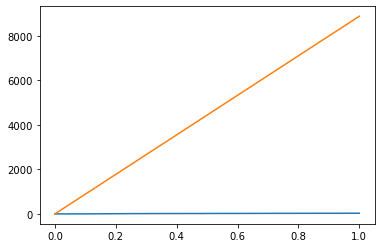

In [91]:
# Plot all precentages:
count = []
for p,i in zip(percentages, list(range(0, len(percentages)))):
    count+=[sum([len(l['matchP'])+len(l['matchT']) for l in summary[str(p)].values()])]
               
sns.lineplot(percentages, count)
sns.lineplot(percentages, np.array([len(data)]*len(percentages))*np.array(percentages))

Well, this does not look very good. The dimensions are just too great, and the matches too few. Looking only at the increase in matches, it does look promising.

In [103]:
import scipy.stats as st

# calculating p-value
z_score = (np.array(count)-np.array(permut['mean']))/np.array(permut['std'])


#cumulative distribution function
# --> not sure if I should take 1- ? for righttailed test? i imagine? 
p_values = 1-st.norm.cdf(z_score)


# significance 5%
top = st.norm.ppf(.975)
bottom = st.norm.ppf(.025)
print('top: ', top)
print('bottom: ', bottom)
z_score

top:  1.959963984540054
bottom:  -1.9599639845400545


array([        nan,  0.53193593, -0.20297224,  0.12216419, -0.33437061,
       -0.66839751, -0.40134589, -0.17311803,  1.01859315,  1.11350172,
        1.71091603,  1.42660275,  1.93696798,  2.47166572,  2.16656967,
        1.8608152 ,  2.3370098 ,  2.00197969,  2.13892517,  1.91261055,
        1.6748503 ,  1.81746062,  1.57739647,  1.36702282,  1.1027132 ,
        1.58890213,  1.37065128,  1.51414051,  1.30921337,  1.08897191,
        0.8732446 ,  1.03823989,  1.18071794,  0.96396408,  1.11849246,
        1.27375344,  1.45046884,  1.23569564,  1.02627356,  0.79660527,
        0.99799194,  0.74696451,  0.45424437,  0.68539443,  0.37061716,
        0.01969091, -0.42158508, -0.14193035,  0.21861798, -0.5095257 ,
               nan])

In [104]:
p_values

array([       nan, 0.29738519, 0.58042164, 0.45138449, 0.63095004,
       0.74806006, 0.65591726, 0.56872067, 0.15419808, 0.13274651,
       0.04354831, 0.07684721, 0.02637463, 0.00672426, 0.01513384,
       0.03138514, 0.00971934, 0.02264346, 0.01622086, 0.02789896,
       0.0469818 , 0.03457331, 0.05735216, 0.08580908, 0.13507587,
       0.05604125, 0.08524184, 0.0649951 , 0.09523104, 0.13808314,
       0.19126489, 0.14957919, 0.1188574 , 0.16753197, 0.13167836,
       0.10137541, 0.07346391, 0.10828586, 0.15238133, 0.21284016,
       0.15914163, 0.22754249, 0.32482648, 0.24654753, 0.35546135,
       0.49214497, 0.66333605, 0.55643249, 0.41347382, 0.69480811,
              nan])

<AxesSubplot:>

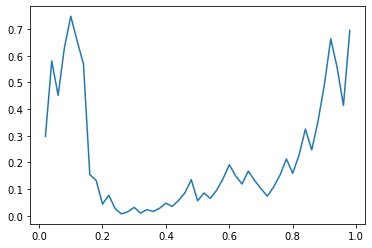

In [105]:
sns.lineplot(percentages, p_values)

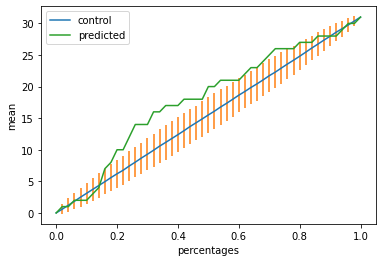

In [94]:
ax = sns.lineplot(data = permut, x ='percentages', y = 'mean', label='control')
ax.errorbar(permut['percentages'], permut['mean'], yerr=permut['std'], fmt=' ', zorder=-1)
ax = sns.lineplot(percentages, count, label='predicted')
ax.legend()


In [ ]:
permut['mean']

fix plot axes labels; could use percentages as cutoff;

# GSEA

In [19]:
smaller = data.reset_index()

In [20]:
smaller['target'] = [x.upper() for x in smaller['target']]

In [21]:
smaller[['target', 'coefficients']].to_csv('greater50.csv')

KeyError: "['coefficients'] not in index"

# Over representation Analysis ORA